***

### Problem

**In this exercise you will use the Portuguese sea battles data that contains outcomes of naval battles between Portuguese and Dutch/British ships between 1583 and 1663. The dataset has following features:**

**_Battle_: Name of the battle place**

**_Year_: Year of the battle**

**_Portuguese ships_: Number of Portuguese ships**

**_Dutch ships_: Number of Dutch ships**

**_English ships_: Number of ships from English side**

**_Ratio of Portuguese to Dutch/British ships_**

**_Spanish Involvement_: $1 = \text{Yes}$, $0 = \text{No}$**

**_Portuguese outcome_: $-1 = \text{Defeat}$, $0 = \text{Draw}$, $1 = \text{Victory}$**

**Use an SVM based model to predict the Portuguese outcome of the battle from the number of ships involved in all sides and Spanish involvement. Try solving the same problem using two other classifiers that you know. Report and compare their results with those from SVM.**

***
***
***

_First we need to import any packages including `pandas`, `numpy`, `pyplot`, `StratifiedKFold`, `svm`, `cross_validate`, `tree`, `GaussianNB`, and `confusion_matrix`._

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

_Now we can load in the Portuguese sea battles data (`armada`)._

In [2]:
df_armada = pd.read_excel('armada.xls', engine = 'xlrd')

_Then we can assign the number of ships involved in all sides (`Prtgship`, `Dtchship`, and `Englship`) and Spanish involvement (`Spanish`) as our features and the Portuguese outcome of a battle (`Result`) as our label._

In [3]:
features = df_armada.drop('Battle', axis = 1).drop('Year', axis = 1).drop('Pratio', axis = 1).drop('Result', axis = 1)
label = df_armada['Result']

_Now, we can split our data into testing and training portions using k-fold stratified cross-validation with 5 randomly split "chunks"._

In [4]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

for train_index, test_index in skf.split(features, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]

TRAIN: [ 0  1  2  3  4  7  8  9 11 12 13 14 15 16 17 18 19 21 22 24 25 27] TEST: [ 5  6 10 20 23 26]
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24 26] TEST: [ 1  2 17 21 25 27]
TRAIN: [ 0  1  2  5  6  8  9 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27] TEST: [ 3  4  7 14 19 24]
TRAIN: [ 1  2  3  4  5  6  7  9 10 11 12 14 15 17 18 19 20 21 23 24 25 26 27] TEST: [ 0  8 13 16 22]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 13 14 16 17 19 20 21 22 23 24 25 26 27] TEST: [ 9 11 12 15 18]


***

#### SVM

_First we will predict the Portuguese outcome of a battle using an SVM model._

***

_To do this, we first load in the SVM classifier._

In [5]:
svm_clf = svm.SVC()

_Then we can fit the SVM classifier to our training data to build our model._

In [6]:
svm_model = svm_clf.fit(X_train, y_train)

_Now we can use this model to predict the Portuguese outcome of a battle from our test features (`X_test`)._

In [7]:
y_pred = svm_model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0], dtype=int64)

_We can also measure the test accuracy using our test features (`X_test`) and test label (`y_test`)._

In [8]:
svm_model.score(X_test, y_test)

0.4

_Since this accuracy is fairly low, we can also look at the confusion matrix._

In [9]:
confusion_matrix(y_test, y_pred)

array([[0, 2, 0],
       [0, 2, 0],
       [0, 1, 0]], dtype=int64)

_After running the model above mulitple times, this confusion matrix seems to generally stay consistant, meaning that the model mostly predicts the result to be 0 (indicating a draw of a battle). We can further inspect this by checking how large our dataset it and whether the data has balanced classes._

In [10]:
len(df_armada)

28

In [11]:
df_armada['Result'].value_counts()

 0    13
-1    10
 1     5
Name: Result, dtype: int64

_The two outputs above indicate that we are working with a very small dataset (which typically is not ideal) and that the classes are generally not balanced (which could be caused by the dataset being so small). In practice we would likely need substantially more data to get better results, though for the purposes of this exercise we can continue with the data we have._

_So, to continue, it would perhaps be better to get an average accuracy of many iterations. So, we can build a function to do this._

In [12]:
# Function for finding the average accuracy of SVM models
# n          ->   number of iterations
# features   ->   the features for the model to use
# label      ->   the label for the model to use
def get_avg_svm_accuracy(n, features, label):
    
    # Set the total training and testing accuracy to be 0
    train_tot_acc = 0
    test_tot_acc = 0
    
    # Set the placeholders for minimum and maximum accuracies
    min_train_score = 2
    max_train_score = -1
    min_test_score = 2
    max_test_score = -1
    
    # Iterate through process n number of times
    for i in range(0, n):
        
        # Set up k-fold cross-validation to split the data randomly into 5 "chunks"
        skf = StratifiedKFold(n_splits = 5, shuffle = True)

        # Measure the accuracy of the model in the iteration
        cross_val = cross_validate(svm_clf, features, label, cv = skf, return_train_score = True)
        
        # Find the accuracy scores in the iteration
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
        
        # Find the average accuracy scores in the iteration
        train_acc = np.mean(train_scores)
        test_acc = np.mean(test_scores)
        
        # Add the average accuracy score in the iteration to the total accuracy score
        train_tot_acc = train_tot_acc + train_acc
        test_tot_acc = test_tot_acc + test_acc
    
    # Find the average accuracy of all the iterations
    train_avg_acc = (train_tot_acc / n)
    test_avg_acc = (test_tot_acc / n)
    
    # Add the variables to a dictionary
    data = {'Train Average Accuracy' : train_avg_acc, 'Test Average Accuracy' : test_avg_acc}
    
    # Turn the `data` dictionary into a dataframe
    df_svm_metrics = pd.DataFrame([data])
    
    # Return the dataframe
    return(df_svm_metrics)

_Now we can use this function to get the average accuracy of the SVM models over the course of 200 iterations._

In [13]:
get_avg_svm_accuracy(200, features, label)

,Train Average Accuracy,Test Average Accuracy
0,0.571923,0.446267


_From this we see that neither the training or testing accuracy is very high, though now we can compare this performance to other types of classifiers._

***

#### Decision Trees

_Next we can predict the Portuguese outcome of a battle using decision trees._

***

_Again, it is better to look at the average accuracy over many iterations. But first, we need to determine what maximum depth should be used for the desicion trees. So, we can build a funtion that takes in features and a label as parameters and plots how the accuracies vary based on the maximum depth._

In [14]:
# Function for ploting the accuracy scores of decision trees at different maximum tree depths
# features   ->   the features for the model to use
# label      ->   the label for the model to use
def plot_dt_max_depth_acc(features, label):
    
    # Create lists to track the maximum depths and respective accuracies of the test and train data
    max_depth = []
    train_max_depth_acc = []
    test_max_depth_acc = []
    
    # Iterate through the maximum depth from 1 to 10
    for i in range (1, 11):
        
        # Add the current maximum depth to the `max_depth` list
        max_depth.append(i)
        
        # Build the DecisionTreeClassifier model and set the max_depth to the given value of i in the iteration and
        # indicate to choose parameters based on the largest expected “information gain” (impurity/entropy)
        d_tree = tree.DecisionTreeClassifier(max_depth = i, criterion = "entropy")
        
        # Measure the accuracy of the model
        cross_val = cross_validate(d_tree, features, label, cv = 5, return_train_score = True)
        
        # Find the accuracy scores given the indicated maximum depth
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
    
        # Find the average accuracy scores given the indicated maximum depth and add them to their respective lists
        train_max_depth_acc.append(np.mean(train_scores))
        test_max_depth_acc.append(np.mean(test_scores))
    
    # Add the lists to a dictionary
    data = {'max_depth' : max_depth,
            'train_max_depth_acc' : train_max_depth_acc,
            'test_max_depth_acc' : test_max_depth_acc}
    
    # Turn the `data` dictionary into a dataframe
    df_max_depth_acc = pd.DataFrame(data)
    
    # Plot the dataframe
    plt.plot(max_depth, train_max_depth_acc, color = 'red', marker = 'o')
    plt.plot(max_depth, test_max_depth_acc, color = 'blue', marker = 'o')
    plt.grid(True)
    plt.title('Decision Tree Depth Accuracies')
    plt.xlabel('Maximum Decision Tree Depth')
    plt.ylabel('Accuracy')
    plt.show()

_Now we can apply this function to determine the decision tree depth._

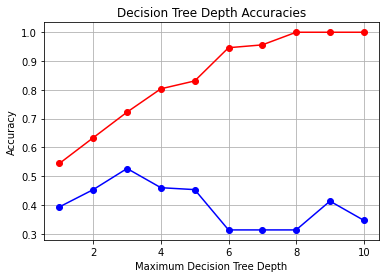

In [15]:
plot_dt_max_depth_acc(features, label)

_From this plot we can see that the accuracy diverges when the maximum decision tree depth is 3, meaning that this is a good value to use as the maximum decision tree depth. Hence, we can assign this to a variable to use going forward._

In [16]:
dt_max_depth = 3

_Now, we can build a similar function as in the case of the SVM model that finds the average accuracy of the decision tree models over many iterations._

In [17]:
# Function for finding the average accuracy of decision trees
# max_depth  ->   maximum decision tree depth
# n          ->   number of iterations
# features   ->   the features for the model to use
# label      ->   the label for the model to use
def get_avg_dt_accuracy(max_depth, n, features, label):

    # Build the DecisionTreeClassifier model and set the max_depth to the given parameter (max_depth) and indicate
    # to choose parameters based on the largest expected “information gain” (impurity/entropy)
    d_tree = tree.DecisionTreeClassifier(max_depth = max_depth, criterion = "entropy")
    
    # Set the total training and testing accuracy to be 0
    train_tot_acc = 0
    test_tot_acc = 0
    
    # Set the placeholders for minimum and maximum accuracies
    min_train_score = 2
    max_train_score = -1
    min_test_score = 2
    max_test_score = -1
    
    # Iterate through process n number of times
    for i in range(0, n):
        
        # Set up stratified k-fold cross-validation to split the data randomly into 5 "chunks"
        skf = StratifiedKFold(n_splits = 5, shuffle = True)

        # Measure the accuracy of the model in the iteration
        cross_val = cross_validate(d_tree, features, label, cv = skf, return_train_score = True)
        
        # Find the accuracy scores in the iteration
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
        
        # Find the average accuracy scores in the iteration
        train_acc = np.mean(train_scores)
        test_acc = np.mean(test_scores)
        
        # Add the average accuracy score in the iteration to the total accuracy score
        train_tot_acc = train_tot_acc + train_acc
        test_tot_acc = test_tot_acc + test_acc
    
    # Find the average accuracy of all the iterations
    train_avg_acc = (train_tot_acc/n)
    test_avg_acc = (test_tot_acc/n)
    
    # Add the variables to a dictionary
    data = {'Train Average Accuracy' : train_avg_acc, 'Test Average Accuracy' : test_avg_acc}
    
    # Turn the `data` dictionary into a dataframe
    df_dt_metrics = pd.DataFrame([data])
    
    # Return the dataframe
    return(df_dt_metrics)

_Now we can use this function to get the average accuracy of the decision tree models over the course of 200 iterations._

In [18]:
get_avg_dt_accuracy(dt_max_depth, 200, features, label)

,Train Average Accuracy,Test Average Accuracy
0,0.713308,0.400533


_Comparing this to the SVM models, we can see that the decision tree models have a higher average training accuracy though a slightly lower average testing accuracy._

***

#### Naive Bayes

_Lastly we can predict the Portuguese outcome of a battle using Naive Bayes._

***

_Same as with the first two types of models, it is better to look at the average accuracy over many iterations. So, we can build a similar function that finds the average accuracy of the Naive Bayes models over many iterations._

In [19]:
# Function for finding the average accuracy of Naive Bayes models
# n          ->   number of iterations
# features   ->   the features for the model to use
# label      ->   the label for the model to use
def get_avg_nb_accuracy(n, features, label):

    # Load in Naive Bayes classifier    
    nb_clf = GaussianNB()
    
    # Set the total training and testing accuracy to be 0
    train_tot_acc = 0
    test_tot_acc = 0
    
    # Set the placeholders for minimum and maximum accuracies
    min_train_score = 2
    max_train_score = -1
    min_test_score = 2
    max_test_score = -1
    
    # Iterate through process n number of times
    for i in range(0, n):
        
        # Set up stratified k-fold cross-validation to split the data randomly into 5 "chunks"
        skf = StratifiedKFold(n_splits=5, shuffle = True)

        # Measure the accuracy of the model in the iteration
        cross_val = cross_validate(nb_clf, features, label, cv = skf, return_train_score = True)
        
        # Find the accuracy scores in the iteration
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
        
        # Find the average accuracy scores in the iteration
        train_acc = np.mean(train_scores)
        test_acc = np.mean(test_scores)
        
        # Add the average accuracy score in the iteration to the total accuracy score
        train_tot_acc = train_tot_acc + train_acc
        test_tot_acc = test_tot_acc + test_acc
    
    # Find the average accuracy of all the iterations
    train_avg_acc = (train_tot_acc/n)
    test_avg_acc = (test_tot_acc/n)
    
    # Add the variables to a dictionary
    data = {'Train Average Accuracy' : train_avg_acc, 'Test Average Accuracy' : test_avg_acc}
    
    # Turn the `data` dictionary into a dataframe
    df_nb_metrics = pd.DataFrame([data])
    
    # Return the dataframe
    return(df_nb_metrics)

_Now we can use this function to get the average accuracy of the Naive Bayes models over the course of 200 iterations._

In [20]:
get_avg_nb_accuracy(200, features, label)

,Train Average Accuracy,Test Average Accuracy
0,0.414506,0.322867


_Comparing this to the SVM models, we can see that the Naive Bayes models have both a lower average training and testing accuracy._

##### _Conclusion:_

_In summary, none of the classifier models performed very well. Comparatively, the SVM models did perform better than the decision tree models and the Naive Bayes models, though none of the models produced acceptable accuracy scores. However, as noted previously, it is typically not ideal to be working with such a small dataset, which is likely why none of our models performed very well. In practice, we would have access to more data to train our models on which would likely improve model performance._